In [0]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import dateutil.parser #converts all common date formats from string to datetime

# Import Data

In [0]:
data = pd.read_csv('2017_Toronto_Bikeshare.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492370 entries, 0 to 1492369
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trip_id                1492370 non-null  object 
 1   trip_start_time        1492369 non-null  object 
 2   trip_stop_time         1492369 non-null  object 
 3   trip_duration_seconds  1492369 non-null  float64
 4   from_station_id        1492369 non-null  object 
 5   from_station_name      1492368 non-null  object 
 6   to_station_id          1492369 non-null  object 
 7   to_station_name        465476 non-null   object 
 8   user_type              465476 non-null   object 
dtypes: float64(1), object(8)
memory usage: 691.0 MB


In [0]:
data.tail(2)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1492368,2383646,12/31/17 23:49:41,12/31/17 23:57:41,480.0,Phoebe St / Spadina Ave,Simcoe St / Queen St W,Member,NaN,NaN
1492369,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data cleaning

## Missing Values

In [0]:
data.isnull().sum()
#check for missing values (recognized by python as such) per column
# from_station_name has 2 NaN, good point to start investigating

trip_id                        0
trip_start_time                1
trip_stop_time                 1
trip_duration_seconds          1
from_station_id                1
from_station_name              2
to_station_id                  1
to_station_name          1026894
user_type                1026894
dtype: int64

In [0]:
data[data['from_station_name'].isnull()]
# these two rows are useless and contain the other column's missing values
# .isnull().index.tolist() gives list of row indices containing missing values

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1424602,2302635,11/29/17 05:53:54,NULLNULL,0.0,Seaton St / Dundas St E,NaN,Casual,NaN,NaN
1492369,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data.shape
# check the original amount of rows

(1492370, 9)

In [0]:
data.drop(data[data['from_station_name'].isnull()].index,inplace=True)
# drops last row of dataframe, since they're all NaNs anyway.
# drops a trip that wasn't finished, via the index of the row that contains the missing value
data.index = range(len(data['trip_id']))
#re-count the indices of the dataframe after dropping rows
data.shape
# check if two rows were deleted

(1492368, 9)

In [0]:
missing = data['user_type'].isna()
#filter for rows that have missing values in them (where the station_id wasn't reported anymore, causing a shift in the data columns)

data['user_type'][missing] = data['to_station_id'][missing]
data['to_station_name'][missing] = data['from_station_name'][missing]
data['to_station_id'][missing] = [0] * len(data['to_station_id'][missing])
data['from_station_name'][missing] = data['from_station_id'][missing]
data['from_station_id'][missing] = [0] * len(data['from_station_id'][missing])
#shift the data back into its original columns, and filling the station_ids with zeros


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Se

In [0]:
data['from_station_id'] = data['from_station_id'].astype('category')
data['from_station_name'] = data['from_station_name'].astype('category')
data['to_station_id'] = data['to_station_id'].astype('category')
data['to_station_name'] = data['to_station_name'].astype('category')
data['user_type'] = data['user_type'].astype('category')
#converting these columns from strings to categorical values in order to reduce file size

In [0]:
data.info(memory_usage='deep')
#memory usage of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492368 entries, 0 to 1492367
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   trip_id                1492368 non-null  object  
 1   trip_start_time        1492368 non-null  object  
 2   trip_stop_time         1492368 non-null  object  
 3   trip_duration_seconds  1492368 non-null  float64 
 4   from_station_id        1492368 non-null  category
 5   from_station_name      1492368 non-null  category
 6   to_station_id          1492368 non-null  category
 7   to_station_name        1492368 non-null  category
 8   user_type              1492368 non-null  category
dtypes: category(5), float64(1), object(3)
memory usage: 282.5 MB


## First Column: trip_id

In [0]:
list(enumerate(data['trip_id'],712382))[-1]
#Check if trip_id is sequential, by enumarting and comparing the last two numbers

(2204749, '2383646')

In [0]:
problems = []

for each in data['trip_id']:
    if isinstance(each,str) and each.isnumeric():
        problems.append(False)
    elif isinstance(each,int):
        problems.append(False)
    else:
        problems.append(True)

data[problems]
#all string are numeric, the rest are integers

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type


In [0]:
data['trip_id'] = list(map(int, data['trip_id']))
#turn all strings into int for the ID column

In [0]:
data.iloc[615:620,]

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
615,713023,2/1/2017 12:41,2/1/2017 12:47,345.0,7026,Bay St / St. Joseph St,7058,Huron/ Harbord St,Member
616,713025,2/1/2017 12:42,2/1/2017 12:50,505.0,7033,Union Station,7060,Princess St / Adelaide St,Member
617,713033,2/1/2017 12:44,2/1/2017 13:01,1002.0,7094,Chester Station,7029,Bay St / Bloor St W,Member
618,713034,2/1/2017 12:45,2/1/2017 12:59,823.0,7037,Bathurst St / Dundas St W,7188,Exhibition GO (Atlantic Ave),Member
619,713037,2/1/2017 12:50,2/1/2017 12:53,206.0,7066,Willcocks St / St. George St,7062,University Ave / College St,Member


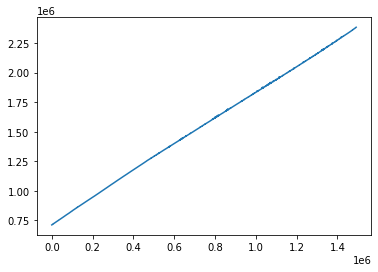

<Figure size 1440x2160 with 0 Axes>

In [0]:
plt.plot(data['trip_id'])
plt.figure(figsize=(20,30))
plt.show()
#trip_id is ascending in order

In [0]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492368 entries, 0 to 1492367
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   trip_id                1492368 non-null  int64   
 1   trip_start_time        1492368 non-null  object  
 2   trip_stop_time         1492368 non-null  object  
 3   trip_duration_seconds  1492368 non-null  float64 
 4   from_station_id        1492368 non-null  category
 5   from_station_name      1492368 non-null  category
 6   to_station_id          1492368 non-null  category
 7   to_station_name        1492368 non-null  category
 8   user_type              1492368 non-null  category
dtypes: category(5), float64(1), int64(1), object(2)
memory usage: 241.3 MB


## Second Column: trip_start_time

Useful function for future use
```
dateutil.parser.parse(data['trip_start_time'][12392],dayfirst=True)
```

In [0]:
date_list = []

for i in range(len(data['trip_start_time'])):
    if i < 465476:
        date_list.append(dt.datetime.strptime(data['trip_start_time'][i], '%d/%m/%Y %H:%M'))
    elif i < 1128964:
        date_list.append(dt.datetime.strptime(data['trip_start_time'][i], '%m/%d/%Y %H:%M'))
    else:
        try:
            dt.datetime.strptime(data['trip_start_time'][i][2:], '%m-%d-%y %H:%M')
        except:
            date_list.append(dt.datetime.strptime(data['trip_start_time'][i], '%m/%d/%y %H:%M:%S'))
        else:
            date_list.append(dt.datetime.strptime(data['trip_start_time'][i][2:], '%m-%d-%y %H:%M'))
      
data['trip_start_time'] = date_list

#Format all strings into datetimes, taking different formats into account
#we have four different date formats, the first two being especially difficult to handle as formats/separators are the same, but day and month are flipped

### Error and sanity check for formatting column

```
pos = [n for n, x in enumerate(data['trip_start_time']) if '/13/17 00:02:39' in x]
pos = [1424602]
print(pos)
```
find position of string that causes trouble parsing as datetime
```
data.iloc[pos[0]-2:pos[0]+3,]
```

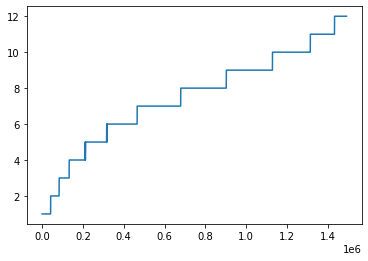

In [0]:
plt.plot([x.month for x in date_list])
#check if month is in ascending order

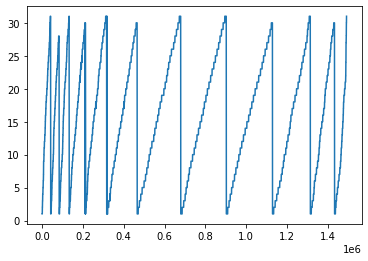

In [0]:
plt.plot([x.day for x in date_list])
#check if day is in ascending order within each month

## Third Column: trip_stop_time

In [0]:
date_list = []
for i in range(len(data['trip_stop_time'])):
    if i < 465476:
        date_list.append(dt.datetime.strptime(data['trip_stop_time'][i], '%d/%m/%Y %H:%M'))
    elif i < 1128964:
        date_list.append(dt.datetime.strptime(data['trip_stop_time'][i], '%m/%d/%Y %H:%M'))
    else:
        try:
            dt.datetime.strptime(data['trip_stop_time'][i][2:], '%m-%d-%y %H:%M')
        except:
            date_list.append(dt.datetime.strptime(data['trip_stop_time'][i], '%m/%d/%y %H:%M:%S'))
        else:
            date_list.append(dt.datetime.strptime(data['trip_stop_time'][i][2:], '%m-%d-%y %H:%M'))
      
data['trip_stop_time'] = date_list

#Format all strings into datetimes, taking different formats into account
#we have four different date formats, the first two being especially difficult to handle as formats/separators are the same, but day and month are flipped

In [0]:
data.info(memory_usage='deep')
#check file size of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492368 entries, 0 to 1492367
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trip_id                1492368 non-null  int64         
 1   trip_start_time        1492368 non-null  datetime64[ns]
 2   trip_stop_time         1492368 non-null  datetime64[ns]
 3   trip_duration_seconds  1492368 non-null  float64       
 4   from_station_id        1492368 non-null  category      
 5   from_station_name      1492368 non-null  category      
 6   to_station_id          1492368 non-null  category      
 7   to_station_name        1492368 non-null  category      
 8   user_type              1492368 non-null  category      
dtypes: category(5), datetime64[ns](2), float64(1), int64(1)
memory usage: 58.5 MB


### Error and sanity check for formatting column

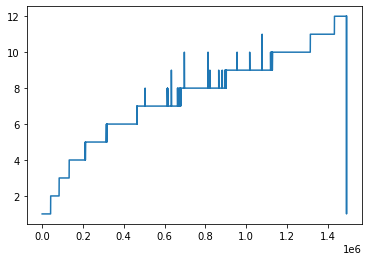

In [0]:
plt.plot([x.month for x in date_list])
#check if month is in ascending order
#the spikes are due to records where the bike has been returned unusually late (sometimes months later, maybe a data error)

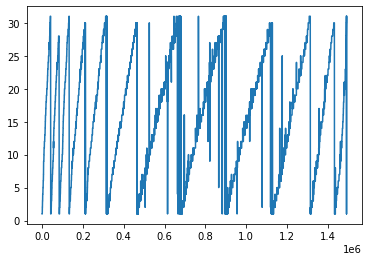

In [0]:
plt.plot([x.day for x in date_list])
#check if day is in ascending order within each month
#the spikes are due to records where the bike has been returned unusually late (sometimes months later, maybe a data error)

## Column 5 and 7: station_id

```
data['from_station_name'].value_counts(dropna=False)
```

In [0]:
for name in data['from_station_name'].unique():
    data['from_station_id'][data['from_station_name'] == name] = data[data['from_station_name'] == name].iloc[0,4]

for name in data['to_station_name'].unique():
    data['to_station_id'][data['to_station_name'] == name] = data[data['to_station_name'] == name].iloc[0,6]

#Filling the remaining station_ids for the according station_names (based off the records where station_ids where actually reported)

In [0]:
data[data['from_station_id'] == 0]['from_station_name'].unique()
#check if from_station_id and to_station_id have the same amount of different names/ids

[Princess St / Adelaide St E, Widmer St / Adelaide St W, Michael Sweet Ave / St. Patrick St, Sherbourne St / Wellesley St E, HTO Park (Queens Quay W), ..., Vanauley St / Queen St W - SMART, Summerhill Ave / MacLennan Ave - SMART, Bloor St W / Shaw Ave - SMART, Exhibition GO Station, Fringe Next Stage - 7219]
Length: 93
Categories (93, object): [Princess St / Adelaide St E, Widmer St / Adelaide St W,
                          Michael Sweet Ave / St. Patrick St, Sherbourne St / Wellesley St E, ...,
                          Summerhill Ave / MacLennan Ave - SMART, Bloor St W / Shaw Ave - SMART, Exhibition GO Station,
                          Fringe Next Stage - 7219]

In [0]:
data[data['to_station_id'] == 0]['to_station_name'].unique()
#check if from_station_id and to_station_id have the same amount of different names/ids

[424 Wellington St W, HTO Park (Queens Quay W), Dundas St W / Yonge St, Wellesley St E / Yonge St (Green P), College St / Major St, ..., Dovercourt Rd / Harrison St - SMART, Vanauley St / Queen St W - SMART, Bloor St W / Manning Ave - SMART, Base Station, Fringe Next Stage - 7219]
Length: 93
Categories (93, object): [424 Wellington St W, HTO Park (Queens Quay W), Dundas St W / Yonge St,
                          Wellesley St E / Yonge St (Green P), ..., Vanauley St / Queen St W - SMART,
                          Bloor St W / Manning Ave - SMART, Base Station, Fringe Next Stage - 7219]

In [0]:
data.to_csv('2017_Toronto_Bikeshare_Clean.csv')